# Final Project

Student 1: Alejandro González Álvarez

NIA 1: 252658

Student 2: Luca Franceschi

NIA 2: 253885

Student 3: Júlia Othats-Dalès

NIA 3: 254435

In [1]:
# ideas

'''
classification of doppelgangers: to which person are you more alike?

input: one facial image
output: closest face in the feature space

siamese network?

use transfer learning or train with vggface2?
fine tune with smaller dataset of doppelgangers

contrastive learning
https://encord.com/blog/guide-to-contrastive-learning/
https://www.v7labs.com/blog/contrastive-learning-guide
'''

'\nclassification of doppelgangers: to which person are you more alike?\n\ninput: one facial image\noutput: closest face in the feature space\n\nsiamese network?\n\nuse transfer learning or train with vggface2?\nfine tune with smaller dataset of doppelgangers\n\ncontrastive learning\nhttps://encord.com/blog/guide-to-contrastive-learning/\nhttps://www.v7labs.com/blog/contrastive-learning-guide\n'

In [2]:
import json
# import umap
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
import scipy.io as sio
from types import MethodType
from torchinfo import summary
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import ResNet18_Weights, mobilenet_v3_small, MobileNet_V3_Small_Weights

/home/lukovsky/Documents/repos/DL-2024/.venv3.8/lib64/python3.8/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
# Comment if not in Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# data_path = '/content/drive/My Drive/DeepLearning_2024/P4/Data/'
# results_path = '/content/drive/My Drive/DeepLearning_2024/P4/Results/'

# Comment if in Google Colab
data_path = 'data/'
results_path = 'results/'

In [4]:
# Print if gpu acceleration is enabled
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
dataset_version = 'F_' # 'F_' for female-only, 'M_' for male-only, empty for both
random_seed = 42 # fixing the seed may result in unexpected results in test function (will be deterministic)
learning_rate = 0.001

# The HDA Doppelgaenger Dataset

In [6]:
'''
https://discuss.pytorch.org/t/torch-utils-data-dataset-random-split/32209/4
'''

'\nhttps://discuss.pytorch.org/t/torch-utils-data-dataset-random-split/32209/4\n'

In [7]:
class HDA_Doppelgaenger(torch.utils.data.Dataset):

    def __init__(self, datadir = data_path, seed = None, dataset_version = '', transform=None):

        self.datadir = datadir
        self.transform = transform
        self.seed = seed

        with open('./' + dataset_version + 'dataset.json', 'r') as fp:
            self.indexer = json.load(fp)['HDA_Doppelgaenger']

    def __getitem__(self, index):
        np.random.seed(self.seed)
        neg_idx = np.random.randint(0, len(self.indexer)) # index
        np.random.seed(self.seed)
        neg_type = np.random.choice([0, 1]) # original or lookalike

        anchor = Image.open(self.datadir + self.indexer[index][0])
        positive = Image.open(self.datadir + self.indexer[index][1])
        negative = Image.open(self.datadir + self.indexer[neg_idx][neg_type])

        if self.transform is not None :
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative
    
    def __len__(self):
        return len(self.indexer)
    
    def mean(self):
        sum = np.zeros(3)
        for i in range(len(self)):
            sum += np.array(self[i][0]).sum(axis=(0,1))
            sum += np.array(self[i][1]).sum(axis=(0,1))
        return sum / (len(self)*2) / 255 / 256**2
    
    def mean_std(self):
        mean = self.mean()

        sum = np.zeros(3)
        for i in range(len(self)):
            sum += np.power(np.array(self[i][0]), 2).sum(axis=(0,1))
            sum += np.power(np.array(self[i][1]), 2).sum(axis=(0,1))
        sum = sum / (len(self)*2) / 255 / 256**2
        
        return mean, np.sqrt(sum - np.power(mean, 2))

In [8]:
class HDA_Subset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        a, p, n = self.subset[index]
        if self.transform:
            a = self.transform(a)
            p = self.transform(p)
            n = self.transform(n)
        return a, p, n
        
    def __len__(self):
        return len(self.subset)

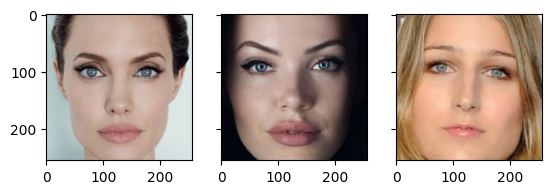

In [9]:
dataset = HDA_Doppelgaenger(seed=random_seed, dataset_version=dataset_version) # !!! if seed is used, accuracy in test function will not work as expected

HDA_mean, HDA_std = dataset.mean_std()

base_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(HDA_mean, HDA_std)])

augm_transform = transforms.Compose(
     [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomGrayscale(0.2),
     transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
     transforms.RandomAffine(45),
     transforms.ToTensor(),
     transforms.Normalize(HDA_mean, HDA_std)])

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)

axs[0].imshow(dataset[0][0])
axs[1].imshow(dataset[0][1])
axs[2].imshow(dataset[0][2])
plt.show()

# Transforms and dataloaders

In [10]:
reduction = 8 # the batches' size will be = len(dataset) / reduction

generator = None
if random_seed != None:
    generator = torch.Generator().manual_seed(random_seed) # to have reproducible results

train, validation, test = random_split(dataset, [0.85, 0.1, 0.05], generator=generator)

train = HDA_Subset(train, augm_transform)
validation = HDA_Subset(validation, base_transform)
test = HDA_Subset(test, base_transform)

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=int(len(train)/reduction), shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation, batch_size=int(len(validation)/reduction), shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=int(len(test)/reduction), shuffle=True)

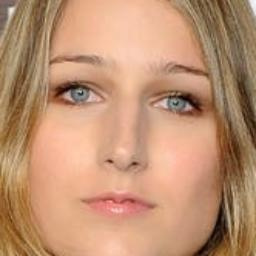

In [11]:
toimage = transforms.ToPILImage()
# toimage(validation[0][2])
dataset[0][2]

# Choose ONE architecture

We have tried several architectures, our recommendation is to run one at a time so there are no confusions. The easiest way to do that is to use the feature "Run Cells in section" from a single architecture at a time. After each training and testing execution, models and training losses are automatically saved based on which is the last architecture selected.

## ResNet-18

This is our re-implementation of the ResNet-18 architecture extracted from [the torchvision github repository](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py). We believe that it is important to note that it is not a simple copy-paste, we have put our best efforts in understanding and re-implementing it to fufill our needs.

### Basic ResNet building block

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None):
        super(ResidualBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = norm_layer(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, bias=False) # in this one stride = 1 then image shape is kept
        self.bn2 = norm_layer(planes)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x): # Tip for improving performance merge all into one line relu(bn2(conv2(relu(bn1(conv1(x))))))
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

### ResNet Architecture

In [13]:
'''
https://arxiv.org/pdf/1512.03385
https://www.geeksforgeeks.org/residual-networks-resnet-deep-learning/
https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
'''

'\nhttps://arxiv.org/pdf/1512.03385\nhttps://www.geeksforgeeks.org/residual-networks-resnet-deep-learning/\nhttps://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py\n'

In [14]:
class ResNet(nn.Module):

    def __init__(self, layers, num_classes=1000, zero_init_residual=False, norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        # Introduction layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layers
        self.layer1 = self._make_layer(64, 64, layers[0])
        self.layer2 = self._make_layer(64, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(128, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(256, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Last fully connected layer
        self.fc = nn.Linear(512, num_classes)

        # What is going on ???
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        # if zero_init_residual:
        #     for m in self.modules():
        #         if isinstance(m, Bottleneck):
        #             nn.init.constant_(m.bn3.weight, 0)
        #         elif isinstance(m, BasicBlock):
        #             nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, in_planes, out_planes, blocks, stride=1):
        '''
        Creates a layer containing {blocks} ResidualBlocks, where the first one downsamples the output if needed,
        and the next {blocks-1} stacked blocks keep the amount of filters unaltered.
        '''
        norm_layer = self._norm_layer
        downsample = None
        if stride != 1 or in_planes != out_planes:
            downsample = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                norm_layer(out_planes)
            )

        layers = []
        layers.append(ResidualBlock(in_planes, out_planes, stride, downsample, norm_layer))

        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_planes, out_planes, norm_layer=norm_layer))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        return x

In [15]:
summary(ResNet([2, 2, 2, 2], 1000), input_size=(128,3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 512, 1, 1]          513,000
├─Conv2d: 1-1                            [128, 64, 128, 128]       9,408
├─BatchNorm2d: 1-2                       [128, 64, 128, 128]       128
├─ReLU: 1-3                              [128, 64, 128, 128]       --
├─MaxPool2d: 1-4                         [128, 64, 64, 64]         --
├─Sequential: 1-5                        [128, 64, 64, 64]         --
│    └─ResidualBlock: 2-1                [128, 64, 64, 64]         --
│    │    └─Conv2d: 3-1                  [128, 64, 64, 64]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 64, 64]         128
│    │    └─ReLU: 3-3                    [128, 64, 64, 64]         --
│    │    └─Conv2d: 3-4                  [128, 64, 64, 64]         36,864
│    │    └─BatchNorm2d: 3-5             [128, 64, 64, 64]         128
│    │    └─ReLU: 3-6                    [128, 64, 64, 64]        

### How pretrained weights are loaded

In [16]:
pretrained_weights = ResNet18_Weights.DEFAULT.get_state_dict()
net = ResNet([2, 2, 2, 2]).to(device)
net.load_state_dict(pretrained_weights)
# TRY WITH fishernet vgg16
net.fc = None

### Saving model and losses

In [17]:
model_name = 'resnet'

## VGG-16

In [ ]:
'''
https://arxiv.org/pdf/1409.1556

TOO MANY PARAMS 135M LOL no way this works on a 800 sample dataset
'''

## MobileNet V3 (small)

In [ ]:
'''
https://arxiv.org/pdf/1905.02244
https://github.com/pytorch/vision/blob/main/torchvision/models/mobilenetv3.py
https://stackoverflow.com/a/73545468/20764091
'''

### MobileNet V3 Architecture changes

In [ ]:
net = mobilenet_v3_small().to(device)
# monkey patching forward method to repurpose this network
def _forward_impl2(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)

        x = self.avgpool(x)
        # x = torch.flatten(x, 1)

        # x = self.classifier(x)

        return x

net._forward_impl = MethodType(_forward_impl2, net)

In [ ]:
summary(net, input_size=(128,3,256,256))

### How pretrained weights are loaded

In [ ]:
pretrained_weights = MobileNet_V3_Small_Weights.DEFAULT.get_state_dict()
net.load_state_dict(pretrained_weights)

### Saving model and losses

In [ ]:
model_name = 'mobilenet'

# Training function

In [32]:
'''
https://stackoverflow.com/a/73704579/20764091
https://www.v7labs.com/blog/triplet-loss
https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html
https://medium.com/@Skpd/triplet-loss-on-imagenet-dataset-a2b29b8c2952
https://omoindrot.github.io/triplet-loss
https://arxiv.org/pdf/1503.03832v3
'''

'\nhttps://stackoverflow.com/a/73704579/20764091\nhttps://www.v7labs.com/blog/triplet-loss\nhttps://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html\nhttps://medium.com/@Skpd/triplet-loss-on-imagenet-dataset-a2b29b8c2952\nhttps://omoindrot.github.io/triplet-loss\nhttps://arxiv.org/pdf/1503.03832v3\n'

In [18]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, net, validation_loss, dataset_version, model_name):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0

            # save trained model
            torch.save(net.state_dict(), results_path + dataset_version + model_name + '.ckpt')

        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [19]:
def validate(net, val_loader, scheduler=None):
    net.eval()

    loss_list = []

    criterion = nn.TripletMarginLoss()

    val_loss_epoch = 0

    for anchors, positives, negatives in val_loader: # batches of positive, negative and anchor images

        anchors = anchors.to(device)
        positives = positives.to(device)
        negatives = negatives.to(device)

        out_anc = net(anchors)
        out_pos = net(positives)
        out_neg = net(negatives)

        loss = criterion(out_anc, out_pos, out_neg)

        batch_loss = loss.cpu().item()

        scheduler.step(loss)

        val_loss_epoch += batch_loss
        
        loss_list.append(batch_loss)

    return val_loss_epoch / len(val_loader), loss_list

In [20]:
def fit(net, tr_loader, val_loader, epochs=10, optimizer=None, scheduler=None, dataset_version='', model_name='default', early_stopper_tolerance=0.1):
    
    loss_list = {
        'training': [],
        'validation': []
    }

    criterion = nn.TripletMarginLoss()

    early_stopper = EarlyStopper(patience=3, min_delta=early_stopper_tolerance)

    for e in range(0, epochs):

        net.train()

        loss_list['training'].append([])
        loss_list['validation'].append([])

        tr_loss_epoch = 0

        for anchors, positives, negatives in tr_loader: # batches of positive, negative and anchor images

            anchors = anchors.to(device)
            positives = positives.to(device)
            negatives = negatives.to(device)

            out_anc = net(anchors)
            out_pos = net(positives)
            out_neg = net(negatives)

            loss = criterion(out_anc, out_pos, out_neg)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tr_loss_epoch += loss.cpu().item()
            
            loss_list['training'][e].append(loss.cpu().item())

        tr_loss_epoch /= len(tr_loader)

        val_loss_epoch, val_loss_list = validate(net, val_loader, scheduler)
        loss_list['validation'][e] = val_loss_list

        print('Epoch [{:4n}/{:4n}]  |  Train Loss: {:.5f}  |  Validation Loss: {:.5f}'.format(e+1, epochs, tr_loss_epoch, val_loss_epoch))

        if early_stopper.early_stop(net, val_loss_epoch, dataset_version, model_name):
            return loss_list
        
    return loss_list

# Test function

In [21]:
def test_epoch(net, test_loader, verbose=False):
    correct = wrong = 0
    mean_near = mean_far = 0

    for anchor, positive, negative in test_loader: # batches of positive, negative and anchor images

        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        out_anc = net(anchor).flatten().detach().cpu().numpy()
        out_pos = net(positive).flatten().detach().cpu().numpy()
        out_neg = net(negative).flatten().detach().cpu().numpy()

        near = np.linalg.norm(out_anc - out_pos, 2)
        far = np.linalg.norm(out_anc - out_neg, 2)

        mean_near += near
        mean_far += far

        if far > near:
            correct += 1
        else:
            wrong += 1

        if verbose:
            print('D: {:>8.4f}  |  ND: {:>8.4f}'.format(near, far))

    return correct, wrong, mean_near, mean_far

def test(net, test_loader):

    print('{:=^28}'.format(' Losses '))

    correct, wrong, mean_near, mean_far = test_epoch(net, test_loader, verbose=True)

    # TODO: PRINT IMAGES, LATENT SPACE, ETC --> BASICALLY TEST IS FOR VISUALIZATION OF SPECIFIC RESULTS

    print('\n{:=^28}'.format(' More stats '))

    epochs = 49 # one done before
    for _ in range(epochs):
        c, w, n, f = test_epoch(net, test_loader)
        correct += c
        wrong += w
        mean_near += n
        mean_far += f

    print('Accuracy: {:>18.2%}'.format(correct/((correct+wrong))))
    print('{:-^28}'.format(' Mean '))
    print('D: {:>8.4f}  |  ND: {:>8.4f}'.format(mean_near/(len(test_loader)*(epochs+1)), mean_far/(len(test_loader)*(epochs+1))))

# Training Loop

In [22]:
print('Training {} on {}dataset with lr={}'.format(model_name, dataset_version, learning_rate))

Training resnet on F_dataset with lr=0.001


In [23]:
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer)
list_loss = fit(net, train_loader, validation_loader, 20, optimizer=optimizer, scheduler=scheduler, 
                dataset_version=dataset_version, model_name=model_name, early_stopper_tolerance=0.05)

sio.savemat(results_path + 'll_' + dataset_version + model_name + '.mat', list_loss)

Epoch [   1/  20]  |  Train Loss: 0.97928  |  Validation Loss: 0.80233
Epoch [   2/  20]  |  Train Loss: 0.83906  |  Validation Loss: 0.76310
Epoch [   3/  20]  |  Train Loss: 0.62815  |  Validation Loss: 0.44270
Epoch [   4/  20]  |  Train Loss: 0.46724  |  Validation Loss: 0.48205
Epoch [   5/  20]  |  Train Loss: 0.50107  |  Validation Loss: 0.46662
Epoch [   6/  20]  |  Train Loss: 0.47613  |  Validation Loss: 0.49743
Epoch [   7/  20]  |  Train Loss: 0.46574  |  Validation Loss: 0.45196
Epoch [   8/  20]  |  Train Loss: 0.44251  |  Validation Loss: 0.50460
Epoch [   9/  20]  |  Train Loss: 0.49341  |  Validation Loss: 0.46396
Epoch [  10/  20]  |  Train Loss: 0.44463  |  Validation Loss: 0.48629
Epoch [  11/  20]  |  Train Loss: 0.49270  |  Validation Loss: 0.45526
Epoch [  12/  20]  |  Train Loss: 0.48424  |  Validation Loss: 0.46510
Epoch [  13/  20]  |  Train Loss: 0.44570  |  Validation Loss: 0.48079
Epoch [  14/  20]  |  Train Loss: 0.42930  |  Validation Loss: 0.49523


# Reloading models before testing

REMEMBER BEFORE TESTING!

RELOAD THE MODEL FROM THE CHECKPOINT, OTHERWISE THE TESTING WILL BE SUBOPTIMAL

In [24]:
pretrained_weights = torch.load(results_path + dataset_version + model_name + '.ckpt', weights_only=True, map_location=device)

In [25]:
if model_name=='resnet':
    net = ResNet([2, 2, 2, 2]).to(device)
    net.fc = None
    net.load_state_dict(pretrained_weights)
elif model_name=='mobilenet':
    net = mobilenet_v3_small().to(device)
    net._forward_impl = MethodType(_forward_impl2, net)
    net.load_state_dict(pretrained_weights)
else:
    print('Something\'s wrong...')

# Plotting results

In [26]:
loadedDict = {}
sio.loadmat(results_path + 'll_' + dataset_version + model_name + '.mat', loadedDict)

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sat Jun  8 19:03:20 2024',
 '__version__': '1.0',
 '__globals__': [],
 'training': array([[1.03242385, 0.99182183, 0.9738974 , 0.98271543, 1.01965046,
         0.94573593, 0.9388963 , 1.02041042, 0.9079423 ],
        [1.01469791, 0.87916803, 0.8876223 , 0.88143903, 0.91608685,
         0.74852973, 0.75110102, 0.70864326, 0.76422715],
        [0.67926753, 0.70166272, 0.73109692, 0.68434548, 0.68999565,
         0.63082254, 0.57220858, 0.52615112, 0.43776345],
        [0.49906945, 0.63109237, 0.57386178, 0.43794435, 0.47575638,
         0.54157722, 0.41404596, 0.48958078, 0.14223349],
        [0.58440828, 0.47027162, 0.44415188, 0.40502802, 0.42340836,
         0.39444837, 0.45882544, 0.40301529, 0.92606992],
        [0.4133743 , 0.49314409, 0.66008312, 0.54393482, 0.44505057,
         0.48020217, 0.4634394 , 0.56005341, 0.22587773],
        [0.45741999, 0.39756247, 0.44100425, 0.4040606 , 0.36684459,
         0.51589137, 

In [27]:
np.array(loadedDict['training']).sum(axis=0)/len(train_loader)

array([0.86314762, 0.83801999, 0.9033133 , 0.82546277, 0.81813512,
       0.84733674, 0.8102262 , 0.78759966, 0.89591907])

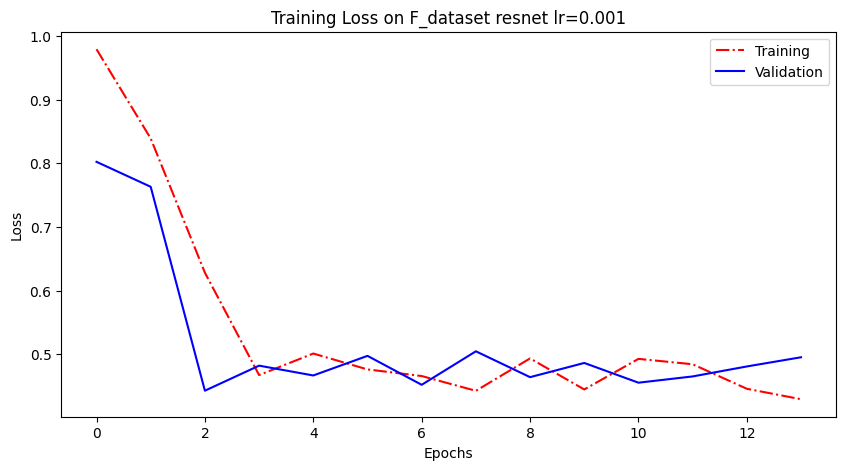

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(loadedDict['training']).mean(axis=1), linestyle='-.', color='r', label='Training')
plt.plot(np.array(loadedDict['validation']).mean(axis=1), linestyle='-', color='b', label='Validation')
plt.title('Training Loss on {}dataset {} lr={}'.format(dataset_version, model_name, learning_rate))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

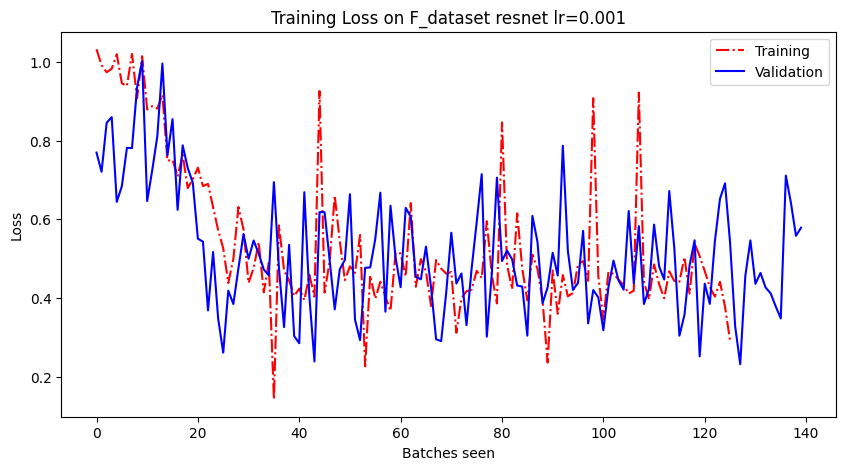

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(loadedDict['training']).flatten(), linestyle='-.', color='r', label='Training')
plt.plot(np.array(loadedDict['validation']).flatten(), linestyle='-', color='b', label='Validation')
plt.title('Training Loss on {}dataset {} lr={}'.format(dataset_version, model_name, learning_rate))
plt.xlabel('Batches seen')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
test(net, test_loader)

========== Losses ==========
D:   0.7666  |  ND:   1.3425
D:   0.6872  |  ND:   1.3176
D:   0.8874  |  ND:   1.4743
D:   0.5992  |  ND:   1.4311
D:   0.5570  |  ND:   1.4331
D:   0.9561  |  ND:   1.3557
D:   0.8282  |  ND:   1.3123
D:   0.5933  |  ND:   1.3157
D:   0.9680  |  ND:   1.3070
D:   0.9324  |  ND:   1.4767

======== More stats ========
Accuracy:            100.00%
----------- Mean -----------
D:   0.7775  |  ND:   1.3766


In [ ]:
# dataset_tr = HDA_Doppelgaenger(dataset_version=dataset_version, transform=base_transform)

# mapper = umap.UMAP().fit(dataset_tr) # CANNOT FIND 2D VISUALIZATION !!!
# umap.plot.points(mapper)